In [1]:
! pip install onnx onnxruntime torch scikit-learn pandas tqdm numpy gensim nltk matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.6 MB/s eta 0:00:00


**1. Import Libraries and Set Up Environment**

In [2]:
# Standard library imports
import os

# Third-party imports
import nltk
import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

**2. Load and Prepare Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
csv_path = '/content/drive/My Drive/cleaned_dataset.csv'

data = pd.read_csv(csv_path)

data.head()

,cleaned_tweet,lable
0,መግደል ቂም ፈጥሮ በበቀል ግድያ ግድያ ይጋብዛል አረመኔው ረግጦ ገዝቶ ዘ...,0
1,ትንሿ ወር ጳጉሜ ይጠርልሽ ትግራይ የሀዘንሽ እድሜ,1
2,እንዲህ አስተያየትም ወቀሳ የመስጠት የሞራል ብቃት የለህም መጀመሪያ ምንም...,0
3,ወረኛ ሲጠላህ እማይልህ የለም ካናቢስ እያስጠቀመ ውግያ ያስገባል ሲልህ አ...,0
4,ብዙ ኢትዮጵያውያን ለፌደራል መከላከያ ሰራዊት የትግራይ ህዝብ ጨፈጨፈ እያ...,0


In [5]:
rows, columns = data.shape

print(f"\n Number of rows in the dataset: {rows}")


 Number of rows in the dataset: 61718


### Tokenization and Word2Vec Embedding

This section focuses on preprocessing textual data by converting it into a structured numerical format suitable for machine learning models. Tokenization involves breaking down text into individual words or tokens, while Word2Vec embedding represents these tokens as dense, fixed-length vectors in a continuous vector space, capturing semantic relationships between words. This approach enables the model to better understand the contextual meaning of words in the dataset.

In [6]:
data['cleaned_tweet'] = data['cleaned_tweet'].astype(str)

In [8]:
import nltk
nltk.download('punkt_tab')

data['tokens'] = data['cleaned_tweet'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
embedding_dimension = 100
window_size = 5
min_word_count = 1
num_workers = 4
training_algorithm = 1
negative_samples = 10
num_epochs = 30

In [11]:
word2vec_model = Word2Vec(
    sentences=data['tokens'],
    vector_size=embedding_dimension,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sg=training_algorithm,
    negative=negative_samples,
    epochs=num_epochs
)

In [12]:
word_vectors = word2vec_model.wv

embedding_dictionary = {word: word_vectors[word] for word in word_vectors.index_to_key}

In [64]:
! pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [65]:
import pickle
import os

drive_directory = '/content/drive/MyDrive/Sentiment_Analysis_Models'
os.makedirs(drive_directory, exist_ok=True)

embedding_file_path = os.path.join(drive_directory, 'embedding_dictionary.pkl')

with open(embedding_file_path, 'wb') as f:
    pickle.dump(embedding_dictionary, f)

print(f'Embedding dictionary successfully saved to {embedding_file_path}')

Embedding dictionary successfully saved to /content/drive/MyDrive/Sentiment_Analysis_Models/embedding_dictionary.pkl


In [13]:
def vectorize_dataset(tokens, embedding_matrix, max_len=10):
    """
    Converts a list of tokens from a tweet into a fixed-size matrix of embedding vectors.

    Parameters:
    - tokens (list of str): Tokenized words from a tweet.
    - embedding_matrix (dict): Mapping from words to their embedding vectors.
    - max_len (int, optional): Desired number of tokens per tweet. Defaults to 10.

    Returns:
    - np.ndarray: A 2D NumPy array of shape (max_len, embedding_dim) representing the vectorized tweet.
                  Each row corresponds to the embedding vector of a token.
                  If the number of tokens is less than max_len, the array is padded with zero vectors.
                  If more, it is truncated to max_len.
    """
    vectors = [
        embedding_matrix[token] if token in embedding_matrix else np.zeros(len(next(iter(embedding_matrix.values()))))
        for token in tokens
    ]


    if len(vectors) < max_len:
        padding = [np.zeros(len(next(iter(embedding_matrix.values()))))] * (max_len - len(vectors))
        vectors.extend(padding)

    else:
        vectors = vectors[:max_len]

    return np.array(vectors)

In [14]:
max_len = 50
data['vectors'] = data['tokens'].apply(lambda x: vectorize_dataset(x, embedding_dictionary, max_len))

In [66]:
word2vec_model.wv.most_similar('ሰላም')

[('የሰውልጀ', 0.741428792476654),
 ('ለሀገራችነእሽ', 0.7401630282402039),
 ('አውርጂለው', 0.7252150774002075),
 ('እምትሆነው', 0.7202683091163635),
 ('በማለተቸው', 0.7180858850479126),
 ('ባገሪቱ', 0.716196596622467),
 ('ዘይበለ', 0.7151095271110535),
 ('አብሽሩበርቱልን', 0.7131639122962952),
 ('ቢአዱ', 0.7115639448165894),
 ('የሚመጣበቴን', 0.7113503217697144)]

### Dataset Splitting: Train, Validation, and Test Sets

This section outlines the process of dividing the dataset into training, validation, and test sets to ensure robust model development. The training set is used for learning, the validation set for tuning, and the test set for final performance evaluation.

In [31]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        post_vector = torch.tensor(self.data.iloc[idx]['vectors'], dtype=torch.float32)
        label = torch.tensor(self.data.iloc[idx]['lable'], dtype=torch.float32)
        post = self.data.iloc[idx]['cleaned_tweet']
        return post, post_vector, label

dataset = SentimentAnalysisDataset(data)

total_length = len(dataset)
train_size = int(0.9 * total_length)
val_size = int(0.1 * total_length)
test_size = int(0.1 * total_length)

train_indices = torch.randperm(total_length)[:train_size].tolist()
val_indices = torch.randperm(total_length)[:val_size].tolist()
test_indices = torch.randperm(total_length)[:test_size].tolist()

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [34]:
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout=0.5):
        """
        Args:
            embedding_dim (int): Dimension of input embeddings.
            hidden_dim (int): Number of features in the hidden state of the LSTM.
            dropout (float): Dropout probability.
        """
        super(SentimentAnalysisLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        self.batch_norm_lstm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, 1)

        self.batch_norm_fc = nn.BatchNorm1d(1)

        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, embedding_dim).

        Returns:
            torch.Tensor: Output probabilities of shape (batch_size, 1).
        """

        _, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]

        hidden = self.batch_norm_lstm(hidden)
        hidden = self.dropout(hidden)

        out = self.fc(hidden)
        out = self.batch_norm_fc(out)

        out = self.sigmoid(out)

        return out

embedding_dim = 100
hidden_dim = 64
model = SentimentAnalysisLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

### Train the Model

In [35]:
drive_directory = '/content/drive/MyDrive/Sentiment_Analysis_Models'

if not os.path.exists(drive_directory):
    os.makedirs(drive_directory)
    print(f"Created directory: {drive_directory}")
else:
    print(f"Directory already exists: {drive_directory}")

Directory already exists: /content/drive/MyDrive/Sentiment_Analysis_Models


In [36]:
pytorch_model_path = os.path.join(drive_directory, "best_sentiment_model.pth")

In [38]:
best_model = SentimentAnalysisLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

early_stop_patience = 150
best_val_acc = 0
early_stop_counter = 0

num_epochs = 100
train_losses, val_accuracies = [], []

In [39]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    train_preds, train_targets , train_texts = [], [] , []

    for texts, vectors, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        vectors, labels = vectors.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(vectors).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        train_texts.extend(texts)

    train_preds_binary = [1 if pred >= 0.5 else 0 for pred in train_preds]
    train_acc = accuracy_score(train_targets, train_preds_binary)
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for texts, vectors, labels in val_loader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors).squeeze()
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_preds_binary = [1 if pred >= 0.5 else 0 for pred in val_preds]
    val_acc = accuracy_score(val_targets, val_preds_binary)
    val_accuracies.append(val_acc)

    log_message = (f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
                  f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(log_message)

    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), pytorch_model_path)
        print(f"Saved best model to {pytorch_model_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

Epoch 1/100: 100%|██████████| 434/434 [00:42<00:00, 10.20it/s]


Epoch 1/100, Loss: 316.3591, Train Accuracy: 0.5112, Validation Accuracy: 0.5242
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 2/100: 100%|██████████| 434/434 [00:45<00:00,  9.47it/s]


Epoch 2/100, Loss: 286.4863, Train Accuracy: 0.6082, Validation Accuracy: 0.6819
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 3/100: 100%|██████████| 434/434 [00:45<00:00,  9.55it/s]


Epoch 3/100, Loss: 261.0914, Train Accuracy: 0.6795, Validation Accuracy: 0.6894
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 4/100: 100%|██████████| 434/434 [00:46<00:00,  9.37it/s]


Epoch 4/100, Loss: 254.7023, Train Accuracy: 0.6894, Validation Accuracy: 0.6984
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 5/100: 100%|██████████| 434/434 [00:45<00:00,  9.49it/s]


Epoch 5/100, Loss: 250.0477, Train Accuracy: 0.6962, Validation Accuracy: 0.7069
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 6/100: 100%|██████████| 434/434 [00:45<00:00,  9.53it/s]


Epoch 6/100, Loss: 246.2054, Train Accuracy: 0.7029, Validation Accuracy: 0.7104
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 7/100: 100%|██████████| 434/434 [00:46<00:00,  9.37it/s]


Epoch 7/100, Loss: 242.5712, Train Accuracy: 0.7094, Validation Accuracy: 0.7221
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 8/100: 100%|██████████| 434/434 [00:45<00:00,  9.57it/s]


Epoch 8/100, Loss: 239.1369, Train Accuracy: 0.7152, Validation Accuracy: 0.7271
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 9/100: 100%|██████████| 434/434 [00:43<00:00,  9.92it/s]


Epoch 9/100, Loss: 235.9256, Train Accuracy: 0.7200, Validation Accuracy: 0.7261


Epoch 10/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 10/100, Loss: 231.5112, Train Accuracy: 0.7263, Validation Accuracy: 0.7399
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 11/100: 100%|██████████| 434/434 [00:46<00:00,  9.37it/s]


Epoch 11/100, Loss: 227.0530, Train Accuracy: 0.7354, Validation Accuracy: 0.7401
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 12/100: 100%|██████████| 434/434 [00:46<00:00,  9.31it/s]


Epoch 12/100, Loss: 222.5171, Train Accuracy: 0.7412, Validation Accuracy: 0.7532
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 13/100: 100%|██████████| 434/434 [00:45<00:00,  9.51it/s]


Epoch 13/100, Loss: 217.3176, Train Accuracy: 0.7516, Validation Accuracy: 0.7491


Epoch 14/100: 100%|██████████| 434/434 [00:45<00:00,  9.45it/s]


Epoch 14/100, Loss: 212.1668, Train Accuracy: 0.7594, Validation Accuracy: 0.7707
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 15/100: 100%|██████████| 434/434 [00:45<00:00,  9.51it/s]


Epoch 15/100, Loss: 206.0923, Train Accuracy: 0.7681, Validation Accuracy: 0.7718
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 16/100: 100%|██████████| 434/434 [00:47<00:00,  9.18it/s]


Epoch 16/100, Loss: 201.1764, Train Accuracy: 0.7769, Validation Accuracy: 0.7798
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 17/100: 100%|██████████| 434/434 [00:45<00:00,  9.53it/s]


Epoch 17/100, Loss: 195.4393, Train Accuracy: 0.7867, Validation Accuracy: 0.7872
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 18/100: 100%|██████████| 434/434 [01:00<00:00,  7.20it/s]


Epoch 18/100, Loss: 190.9217, Train Accuracy: 0.7944, Validation Accuracy: 0.7803


Epoch 19/100: 100%|██████████| 434/434 [00:50<00:00,  8.58it/s]


Epoch 19/100, Loss: 188.9073, Train Accuracy: 0.7959, Validation Accuracy: 0.7903
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 20/100: 100%|██████████| 434/434 [00:45<00:00,  9.47it/s]


Epoch 20/100, Loss: 183.9766, Train Accuracy: 0.8055, Validation Accuracy: 0.7960
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 21/100: 100%|██████████| 434/434 [00:50<00:00,  8.52it/s]


Epoch 21/100, Loss: 178.0221, Train Accuracy: 0.8141, Validation Accuracy: 0.8051
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 22/100: 100%|██████████| 434/434 [00:46<00:00,  9.41it/s]


Epoch 22/100, Loss: 173.7634, Train Accuracy: 0.8201, Validation Accuracy: 0.8067
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 23/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 23/100, Loss: 170.2309, Train Accuracy: 0.8254, Validation Accuracy: 0.8099
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 24/100: 100%|██████████| 434/434 [00:46<00:00,  9.36it/s]


Epoch 24/100, Loss: 167.2529, Train Accuracy: 0.8302, Validation Accuracy: 0.8180
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 25/100: 100%|██████████| 434/434 [00:47<00:00,  9.19it/s]


Epoch 25/100, Loss: 163.8428, Train Accuracy: 0.8355, Validation Accuracy: 0.8033


Epoch 26/100: 100%|██████████| 434/434 [00:45<00:00,  9.54it/s]


Epoch 26/100, Loss: 158.7104, Train Accuracy: 0.8442, Validation Accuracy: 0.7931


Epoch 27/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 27/100, Loss: 153.5456, Train Accuracy: 0.8495, Validation Accuracy: 0.8180


Epoch 28/100: 100%|██████████| 434/434 [00:54<00:00,  7.96it/s]


Epoch 28/100, Loss: 155.1314, Train Accuracy: 0.8475, Validation Accuracy: 0.7817


Epoch 29/100: 100%|██████████| 434/434 [00:46<00:00,  9.31it/s]


Epoch 29/100, Loss: 148.7808, Train Accuracy: 0.8551, Validation Accuracy: 0.7757


Epoch 30/100: 100%|██████████| 434/434 [00:45<00:00,  9.54it/s]


Epoch 30/100, Loss: 147.4583, Train Accuracy: 0.8575, Validation Accuracy: 0.7689


Epoch 31/100: 100%|██████████| 434/434 [00:45<00:00,  9.44it/s]


Epoch 31/100, Loss: 142.1023, Train Accuracy: 0.8646, Validation Accuracy: 0.8300
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 32/100: 100%|██████████| 434/434 [00:46<00:00,  9.37it/s]


Epoch 32/100, Loss: 135.1294, Train Accuracy: 0.8724, Validation Accuracy: 0.8454
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 33/100: 100%|██████████| 434/434 [00:45<00:00,  9.50it/s]


Epoch 33/100, Loss: 130.6954, Train Accuracy: 0.8784, Validation Accuracy: 0.8485
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 34/100: 100%|██████████| 434/434 [00:45<00:00,  9.46it/s]


Epoch 34/100, Loss: 126.5119, Train Accuracy: 0.8836, Validation Accuracy: 0.8433


Epoch 35/100: 100%|██████████| 434/434 [00:46<00:00,  9.30it/s]


Epoch 35/100, Loss: 123.6958, Train Accuracy: 0.8878, Validation Accuracy: 0.8443


Epoch 36/100: 100%|██████████| 434/434 [00:45<00:00,  9.50it/s]


Epoch 36/100, Loss: 122.0448, Train Accuracy: 0.8894, Validation Accuracy: 0.8362


Epoch 37/100: 100%|██████████| 434/434 [00:45<00:00,  9.49it/s]


Epoch 37/100, Loss: 121.4283, Train Accuracy: 0.8897, Validation Accuracy: 0.8423


Epoch 38/100: 100%|██████████| 434/434 [00:46<00:00,  9.34it/s]


Epoch 38/100, Loss: 118.8091, Train Accuracy: 0.8934, Validation Accuracy: 0.8482


Epoch 39/100: 100%|██████████| 434/434 [01:00<00:00,  7.17it/s]


Epoch 39/100, Loss: 116.5527, Train Accuracy: 0.8962, Validation Accuracy: 0.8499
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 40/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 40/100, Loss: 115.5237, Train Accuracy: 0.8969, Validation Accuracy: 0.8543
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 41/100: 100%|██████████| 434/434 [00:46<00:00,  9.29it/s]


Epoch 41/100, Loss: 113.3484, Train Accuracy: 0.9004, Validation Accuracy: 0.8650
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 42/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 42/100, Loss: 113.7041, Train Accuracy: 0.8991, Validation Accuracy: 0.8718
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 43/100: 100%|██████████| 434/434 [00:47<00:00,  9.21it/s]


Epoch 43/100, Loss: 110.8211, Train Accuracy: 0.9019, Validation Accuracy: 0.8741
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 44/100: 100%|██████████| 434/434 [00:46<00:00,  9.35it/s]


Epoch 44/100, Loss: 108.4798, Train Accuracy: 0.9061, Validation Accuracy: 0.8730


Epoch 45/100: 100%|██████████| 434/434 [00:45<00:00,  9.49it/s]


Epoch 45/100, Loss: 109.3001, Train Accuracy: 0.9028, Validation Accuracy: 0.8733


Epoch 46/100: 100%|██████████| 434/434 [00:45<00:00,  9.50it/s]


Epoch 46/100, Loss: 106.6644, Train Accuracy: 0.9069, Validation Accuracy: 0.8692


Epoch 47/100: 100%|██████████| 434/434 [00:45<00:00,  9.62it/s]


Epoch 47/100, Loss: 105.0771, Train Accuracy: 0.9089, Validation Accuracy: 0.8683


Epoch 48/100: 100%|██████████| 434/434 [00:45<00:00,  9.52it/s]


Epoch 48/100, Loss: 104.6849, Train Accuracy: 0.9099, Validation Accuracy: 0.8715


Epoch 49/100: 100%|██████████| 434/434 [00:45<00:00,  9.57it/s]


Epoch 49/100, Loss: 104.6893, Train Accuracy: 0.9100, Validation Accuracy: 0.8736


Epoch 50/100: 100%|██████████| 434/434 [00:44<00:00,  9.66it/s]


Epoch 50/100, Loss: 104.6484, Train Accuracy: 0.9089, Validation Accuracy: 0.8733


Epoch 51/100: 100%|██████████| 434/434 [00:45<00:00,  9.51it/s]


Epoch 51/100, Loss: 99.8025, Train Accuracy: 0.9152, Validation Accuracy: 0.8824
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 52/100: 100%|██████████| 434/434 [00:45<00:00,  9.60it/s]


Epoch 52/100, Loss: 97.4534, Train Accuracy: 0.9187, Validation Accuracy: 0.8804


Epoch 53/100: 100%|██████████| 434/434 [00:44<00:00,  9.66it/s]


Epoch 53/100, Loss: 94.1551, Train Accuracy: 0.9220, Validation Accuracy: 0.8764


Epoch 54/100: 100%|██████████| 434/434 [00:45<00:00,  9.62it/s]


Epoch 54/100, Loss: 94.0400, Train Accuracy: 0.9221, Validation Accuracy: 0.8817


Epoch 55/100: 100%|██████████| 434/434 [00:45<00:00,  9.51it/s]


Epoch 55/100, Loss: 92.2634, Train Accuracy: 0.9247, Validation Accuracy: 0.8835
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 56/100: 100%|██████████| 434/434 [00:45<00:00,  9.60it/s]


Epoch 56/100, Loss: 91.6774, Train Accuracy: 0.9246, Validation Accuracy: 0.8746


Epoch 57/100: 100%|██████████| 434/434 [00:45<00:00,  9.61it/s]


Epoch 57/100, Loss: 91.3684, Train Accuracy: 0.9260, Validation Accuracy: 0.8752


Epoch 58/100: 100%|██████████| 434/434 [00:45<00:00,  9.58it/s]


Epoch 58/100, Loss: 89.3938, Train Accuracy: 0.9281, Validation Accuracy: 0.8772


Epoch 59/100: 100%|██████████| 434/434 [00:45<00:00,  9.52it/s]


Epoch 59/100, Loss: 89.0884, Train Accuracy: 0.9284, Validation Accuracy: 0.8793


Epoch 60/100: 100%|██████████| 434/434 [00:44<00:00,  9.68it/s]


Epoch 60/100, Loss: 88.8933, Train Accuracy: 0.9274, Validation Accuracy: 0.8751


Epoch 61/100: 100%|██████████| 434/434 [00:45<00:00,  9.60it/s]


Epoch 61/100, Loss: 87.4045, Train Accuracy: 0.9289, Validation Accuracy: 0.8773


Epoch 62/100: 100%|██████████| 434/434 [00:45<00:00,  9.56it/s]


Epoch 62/100, Loss: 90.6010, Train Accuracy: 0.9248, Validation Accuracy: 0.8887
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 63/100: 100%|██████████| 434/434 [00:44<00:00,  9.65it/s]


Epoch 63/100, Loss: 87.7172, Train Accuracy: 0.9288, Validation Accuracy: 0.8921
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 64/100: 100%|██████████| 434/434 [00:45<00:00,  9.62it/s]


Epoch 64/100, Loss: 86.2742, Train Accuracy: 0.9298, Validation Accuracy: 0.9010
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 65/100: 100%|██████████| 434/434 [00:45<00:00,  9.63it/s]


Epoch 65/100, Loss: 83.9446, Train Accuracy: 0.9324, Validation Accuracy: 0.9024
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 66/100: 100%|██████████| 434/434 [00:45<00:00,  9.51it/s]


Epoch 66/100, Loss: 82.7349, Train Accuracy: 0.9335, Validation Accuracy: 0.8979


Epoch 67/100: 100%|██████████| 434/434 [00:45<00:00,  9.61it/s]


Epoch 67/100, Loss: 81.9304, Train Accuracy: 0.9347, Validation Accuracy: 0.9041
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 68/100: 100%|██████████| 434/434 [00:44<00:00,  9.68it/s]


Epoch 68/100, Loss: 81.0832, Train Accuracy: 0.9358, Validation Accuracy: 0.9055
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 69/100: 100%|██████████| 434/434 [00:45<00:00,  9.59it/s]


Epoch 69/100, Loss: 80.4897, Train Accuracy: 0.9361, Validation Accuracy: 0.9063
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 70/100: 100%|██████████| 434/434 [00:45<00:00,  9.54it/s]


Epoch 70/100, Loss: 80.0664, Train Accuracy: 0.9372, Validation Accuracy: 0.9060


Epoch 71/100: 100%|██████████| 434/434 [00:44<00:00,  9.65it/s]


Epoch 71/100, Loss: 79.9088, Train Accuracy: 0.9372, Validation Accuracy: 0.9050


Epoch 72/100: 100%|██████████| 434/434 [00:45<00:00,  9.62it/s]


Epoch 72/100, Loss: 79.6307, Train Accuracy: 0.9371, Validation Accuracy: 0.9046


Epoch 73/100: 100%|██████████| 434/434 [00:44<00:00,  9.67it/s]


Epoch 73/100, Loss: 78.8801, Train Accuracy: 0.9382, Validation Accuracy: 0.9033


Epoch 74/100: 100%|██████████| 434/434 [00:45<00:00,  9.56it/s]


Epoch 74/100, Loss: 80.4218, Train Accuracy: 0.9363, Validation Accuracy: 0.9107
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 75/100: 100%|██████████| 434/434 [00:45<00:00,  9.63it/s]


Epoch 75/100, Loss: 79.1231, Train Accuracy: 0.9375, Validation Accuracy: 0.9101


Epoch 76/100: 100%|██████████| 434/434 [00:45<00:00,  9.64it/s]


Epoch 76/100, Loss: 77.9336, Train Accuracy: 0.9388, Validation Accuracy: 0.9120
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 77/100: 100%|██████████| 434/434 [00:45<00:00,  9.52it/s]


Epoch 77/100, Loss: 77.2562, Train Accuracy: 0.9402, Validation Accuracy: 0.9084


Epoch 78/100: 100%|██████████| 434/434 [00:44<00:00,  9.65it/s]


Epoch 78/100, Loss: 76.7609, Train Accuracy: 0.9408, Validation Accuracy: 0.9138
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 79/100: 100%|██████████| 434/434 [00:45<00:00,  9.61it/s]


Epoch 79/100, Loss: 77.0220, Train Accuracy: 0.9401, Validation Accuracy: 0.9127


Epoch 80/100: 100%|██████████| 434/434 [00:44<00:00,  9.66it/s]


Epoch 80/100, Loss: 75.8937, Train Accuracy: 0.9409, Validation Accuracy: 0.9114


Epoch 81/100: 100%|██████████| 434/434 [00:45<00:00,  9.50it/s]


Epoch 81/100, Loss: 79.1898, Train Accuracy: 0.9379, Validation Accuracy: 0.9112


Epoch 82/100: 100%|██████████| 434/434 [00:45<00:00,  9.60it/s]


Epoch 82/100, Loss: 76.2452, Train Accuracy: 0.9408, Validation Accuracy: 0.9141
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 83/100: 100%|██████████| 434/434 [00:44<00:00,  9.65it/s]


Epoch 83/100, Loss: 76.1316, Train Accuracy: 0.9412, Validation Accuracy: 0.9143
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 84/100: 100%|██████████| 434/434 [00:45<00:00,  9.61it/s]


Epoch 84/100, Loss: 75.6961, Train Accuracy: 0.9416, Validation Accuracy: 0.9118


Epoch 85/100: 100%|██████████| 434/434 [00:45<00:00,  9.50it/s]


Epoch 85/100, Loss: 75.1983, Train Accuracy: 0.9422, Validation Accuracy: 0.9167
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 86/100: 100%|██████████| 434/434 [00:44<00:00,  9.66it/s]


Epoch 86/100, Loss: 74.8732, Train Accuracy: 0.9424, Validation Accuracy: 0.9148


Epoch 87/100: 100%|██████████| 434/434 [00:48<00:00,  8.91it/s]


Epoch 87/100, Loss: 75.3903, Train Accuracy: 0.9417, Validation Accuracy: 0.9122


Epoch 88/100: 100%|██████████| 434/434 [00:45<00:00,  9.59it/s]


Epoch 88/100, Loss: 75.2450, Train Accuracy: 0.9421, Validation Accuracy: 0.9152


Epoch 89/100: 100%|██████████| 434/434 [00:44<00:00,  9.82it/s]


Epoch 89/100, Loss: 76.8329, Train Accuracy: 0.9398, Validation Accuracy: 0.9071


Epoch 90/100: 100%|██████████| 434/434 [00:44<00:00,  9.86it/s]


Epoch 90/100, Loss: 75.8028, Train Accuracy: 0.9410, Validation Accuracy: 0.9169
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 91/100: 100%|██████████| 434/434 [00:44<00:00,  9.75it/s]


Epoch 91/100, Loss: 73.4308, Train Accuracy: 0.9438, Validation Accuracy: 0.9180
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 92/100: 100%|██████████| 434/434 [00:45<00:00,  9.47it/s]


Epoch 92/100, Loss: 73.5245, Train Accuracy: 0.9442, Validation Accuracy: 0.9154


Epoch 93/100: 100%|██████████| 434/434 [00:45<00:00,  9.48it/s]


Epoch 93/100, Loss: 73.5180, Train Accuracy: 0.9439, Validation Accuracy: 0.9188
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


Epoch 94/100: 100%|██████████| 434/434 [00:46<00:00,  9.31it/s]


Epoch 94/100, Loss: 72.9578, Train Accuracy: 0.9446, Validation Accuracy: 0.9187


Epoch 95/100: 100%|██████████| 434/434 [00:45<00:00,  9.55it/s]


Epoch 95/100, Loss: 74.2261, Train Accuracy: 0.9432, Validation Accuracy: 0.9175


Epoch 96/100: 100%|██████████| 434/434 [00:45<00:00,  9.47it/s]


Epoch 96/100, Loss: 73.3921, Train Accuracy: 0.9435, Validation Accuracy: 0.9135


Epoch 97/100: 100%|██████████| 434/434 [00:46<00:00,  9.29it/s]


Epoch 97/100, Loss: 73.9573, Train Accuracy: 0.9430, Validation Accuracy: 0.9151


Epoch 98/100: 100%|██████████| 434/434 [00:45<00:00,  9.47it/s]


Epoch 98/100, Loss: 72.8554, Train Accuracy: 0.9432, Validation Accuracy: 0.9182


Epoch 99/100: 100%|██████████| 434/434 [00:45<00:00,  9.46it/s]


Epoch 99/100, Loss: 72.6051, Train Accuracy: 0.9442, Validation Accuracy: 0.9175


Epoch 100/100: 100%|██████████| 434/434 [00:46<00:00,  9.29it/s]


Epoch 100/100, Loss: 71.4996, Train Accuracy: 0.9453, Validation Accuracy: 0.9198
Saved best model to /content/drive/MyDrive/Sentiment_Analysis_Models/best_sentiment_model.pth


## Model Evaluation and Performance Metrics

This section evaluates the model's performance on both the training and test datasets using key metrics such as accuracy, precision, recall, F1-score, and AUC. These metrics provide insights into the model's effectiveness in distinguishing between classes and its overall predictive capability.


In [63]:
from sklearn.metrics import accuracy_score

model.eval()
test_preds, test_targets, test_texts = [], [], []
max_samples = 5
sample_count = 0

with torch.no_grad():
	for texts, vectors, labels in test_loader:
		vectors, labels = vectors.to(device), labels.to(device)
		outputs = model(vectors).squeeze()
		test_preds.extend(outputs.cpu().numpy())
		test_targets.extend(labels.cpu().numpy())
		test_texts.extend(texts)

		sample_count += len(labels)
		if sample_count >= max_samples:
			break

test_preds_binary = [1 if pred >= 0.5 else 0 for pred in test_preds]
test_acc = accuracy_score(test_targets, test_preds_binary)
print(f"Test Accuracy: {test_acc:.4f}")

test_preds_binary = test_preds_binary[:max_samples]
test_targets = test_targets[:max_samples]
test_texts = test_texts[:max_samples]

col_widths = {
	"Sample": max(len("Sample"), len(str(max_samples))),
	"Text": max(len("Text"), max(len(text) for text in test_texts)),
	"Predicted Sentiment": len("Predicted Sentiment"),
	"Actual Sentiment": len("Actual Sentiment"),
}

header = f"{'Sample':<{col_widths['Sample']}}  {'Text':<{col_widths['Text']}}  {'Predicted Sentiment':<{col_widths['Predicted Sentiment']}}  {'Actual Sentiment':<{col_widths['Actual Sentiment']}}"
print(header)
print("=" * len(header))

for i, (text, pred, actual) in enumerate(zip(test_texts, test_preds_binary, test_targets)):
	predicted_sentiment = 'Positive' if pred == 1 else 'Negative'
	actual_sentiment = 'Positive' if actual == 1 else 'Negative'
	print(f"{i + 1:<{col_widths['Sample']}}  {text:<{col_widths['Text']}}  {predicted_sentiment:<{col_widths['Predicted Sentiment']}}  {actual_sentiment:<{col_widths['Actual Sentiment']}}")

Test Accuracy: 0.9375
Sample  Text                                                                              Predicted Sentiment  Actual Sentiment
1       እንግድህ እንላለን ነፍስ ይማር ብለን ዝምምምምምም ፈጣሪም ዝምምም አለ ቃሉ ይፈፀም ግድ ነውና                       Positive             Positive        
2       ታከለ ኡማ የቤተክርክስቲያን መብት ጥሷል                                                         Negative             Negative        
3       ውሻ አገባት እርሻ ብለን ቁጭ እንዳንል በኑሮአችን እየመጡ ቸገረን እኮ                                      Positive             Positive        
4       አፍሪካ ሀብረት ደብረ ምህረት የቅዱስ ሚካኤል ካቴድራል ሰንበት ትምህርት ቤት ባወጣው መግለጫ የሚከተለውን ተንኳሽ ቃል ተጠቅሟል  Positive             Positive        
5       ነፍጠኝነት ይለምልም                                                                      Negative             Negative        


In [49]:
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def evaluate_onnx_model(data_loader, session, max_samples=None):
	"""
	Evaluates the ONNX model on a given DataLoader and calculates evaluation metrics.

	Args:
		data_loader (DataLoader): DataLoader for the dataset to evaluate.
		session (onnxruntime.InferenceSession): Loaded ONNX model session.
		max_samples (int): Maximum number of samples to evaluate (optional).

	Returns:
		tuple: (predictions, targets, texts)
	"""
	preds, targets, texts = [], [], []
	sample_count = 0

	for batch_texts, vectors, labels in data_loader:
		vectors = vectors.numpy()
		labels = labels.numpy()

		ort_inputs = {session.get_inputs()[0].name: vectors}
		ort_outs = session.run(None, ort_inputs)
		outputs = np.squeeze(ort_outs[0])

		preds.extend(outputs)
		targets.extend(labels)
		texts.extend(batch_texts)

		sample_count += len(labels)
		if max_samples and sample_count >= max_samples:
			break

	if max_samples:
		preds = preds[:max_samples]
		targets = targets[:max_samples]
		texts = texts[:max_samples]

	preds_binary = [1 if pred >= 0.5 else 0 for pred in preds]

	return preds, preds_binary, targets, texts

In [50]:
def calculate_metrics(preds, preds_binary, targets):
	"""
	Calculates evaluation metrics for model predictions.

	Args:
		preds (list): Raw model outputs (probabilities).
		preds_binary (list): Binary model predictions.
		targets (list): True labels.

	Returns:
		dict: Evaluation metrics.
	"""
	accuracy = accuracy_score(targets, preds_binary)
	precision = precision_score(targets, preds_binary, average='binary')
	recall = recall_score(targets, preds_binary, average='binary')
	f1 = f1_score(targets, preds_binary, average='binary')
	auc = roc_auc_score(targets, preds)
	report = classification_report(targets, preds_binary, output_dict=True)

	return {
		"accuracy": accuracy,
		"precision": precision,
		"recall": recall,
		"f1_score": f1,
		"auc": auc,
		"classification_report": report
	}

In [51]:
train_preds, train_preds_binary, train_targets, train_texts_eval = evaluate_onnx_model(
	train_loader, session
)
train_metrics = calculate_metrics(train_preds, train_preds_binary, train_targets)

print("\nTrain Metrics:")
for metric, value in train_metrics.items():
	if metric == "classification_report":
		print("\nClassification Report (Train):\n", value)
	else:
		print(f"{metric.capitalize()}: {value:.4f}")

test_preds, test_preds_binary, test_targets, test_texts_eval = evaluate_onnx_model(
	test_loader, session
)
test_metrics = calculate_metrics(test_preds, test_preds_binary, test_targets)

print("\nTest Metrics:")
for metric, value in test_metrics.items():
	if metric == "classification_report":
		print("\nClassification Report (Test):\n", value)
	else:
		print(f"{metric.capitalize()}: {value:.4f}")


Train Metrics:
Accuracy: 0.9461
Precision: 0.9757
Recall: 0.9189
F1_score: 0.9464
Auc: 0.9781

Classification Report (Train):
 {'0.0': {'precision': 0.9178771146203355, 'recall': 0.9753709309713346, 'f1-score': 0.9457510418554086, 'support': 26757.0}, '1.0': {'precision': 0.9756943163795965, 'recall': 0.9188926326027302, 'f1-score': 0.9464419877643018, 'support': 28789.0}, 'accuracy': 0.9460987289813848, 'macro avg': {'precision': 0.9467857154999659, 'recall': 0.9471317817870324, 'f1-score': 0.9460965148098552, 'support': 55546.0}, 'weighted avg': {'precision': 0.9478432583831153, 'recall': 0.9460987289813848, 'f1-score': 0.9461091530024061, 'support': 55546.0}}

Test Metrics:
Accuracy: 0.9219
Precision: 0.9522
Recall: 0.8937
F1_score: 0.9220
Auc: 0.9575

Classification Report (Test):
 {'0.0': {'precision': 0.8933626926706512, 'recall': 0.9520616828695944, 'f1-score': 0.9217786432976306, 'support': 2983.0}, '1.0': {'precision': 0.9522058823529411, 'recall': 0.89366373902133, 'f1-score

### Confusion Matrix: Model Performance on Test Dataset

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(targets, preds_binary, title="Confusion Matrix"):
	"""
	Plots a confusion matrix using true and predicted labels.

	Args:
		targets (list): True labels.
		preds_binary (list): Predicted binary labels.
		title (str): Title for the confusion matrix plot.
	"""
	cm = confusion_matrix(targets, preds_binary)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

	plt.figure(figsize=(8, 6))
	disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
	plt.title(title)
	plt.show()


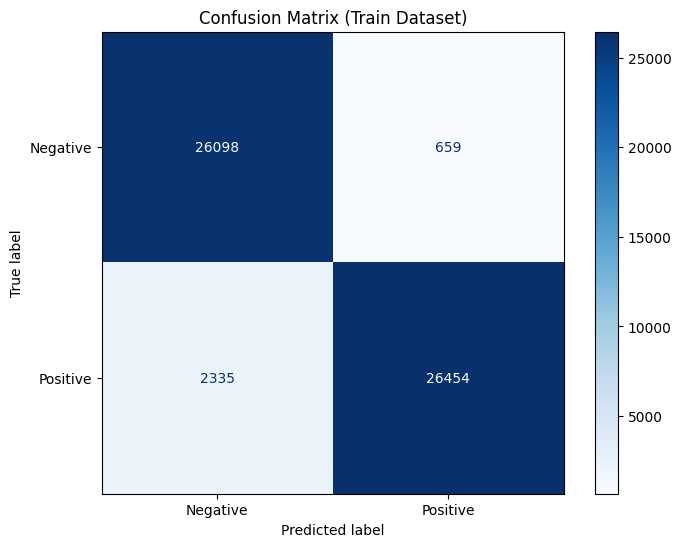

In [61]:
plot_confusion_matrix(train_targets, train_preds_binary, title="Confusion Matrix (Train Dataset)")